<a href="https://colab.research.google.com/github/ansonmiu0214/TypeScript-Multiparty-Sessions/blob/master/benchmarks/Benchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
import os
import shutil

repo_path = '/content/TypeScript-Multiparty-Sessions'
if os.path.exists(repo_path):
    print('Note: deleting stale repo')
    shutil.rmtree(repo_path)

!git clone https://github.com/ansonmiu0214/TypeScript-Multiparty-Sessions
benchmark_path = os.path.join(repo_path, 'benchmarks')
assert os.path.exists(benchmark_path)

Note: deleting stale repo
Cloning into 'TypeScript-Multiparty-Sessions'...
remote: Enumerating objects: 1043, done.
remote: Counting objects: 100% (1043/1043), done.
remote: Compressing objects: 100% (636/636), done.
remote: Total 1043 (delta 592), reused 832 (delta 388), pack-reused 0
Receiving objects: 100% (1043/1043), 643.97 KiB | 908.00 KiB/s, done.
Resolving deltas: 100% (592/592), done.


In [0]:
def from_ms(ms):
    return float(ms[:-2])

def parse_log(content, prefix = 'benchmark'):
    relevant_lines = [line.strip() for line in content
                      if line.startswith(prefix) and line.strip()]

    message_sent = [0]
    elapsed_ms = [0.0]

    for line in relevant_lines[:-1]:
        _, time, count = line.split(' ')
        message_sent.append(int(count))
        elapsed_ms.append(from_ms(time))

    _, total_elapsed_str = relevant_lines[-1].split(' ')
    total_elapsed_ms = from_ms(total_elapsed_str)

    return message_sent, elapsed_ms, total_elapsed_ms

In [0]:
def visualise_logs(label, message_count):
    log_dir = os.path.join(benchmark_path, label, 'server', 'logs')
    relevant_logs = [log for log in os.listdir(log_dir)
                     if int(log.split('_')[0]) == message_count]

    datasets = []
    average_elapsed = 0.0

    for log in relevant_logs:
        log_path = os.path.join(log_dir, log)
        with open(log_path, 'r') as log_file:
            message_count, elapsed, total_elapsed = parse_log(log_file)
            datasets.append((message_count, elapsed))
            average_elapsed += total_elapsed

    average_elapsed /= len(relevant_logs)

    return datasets, average_elapsed

Average elapsed: 2267.0894 ms


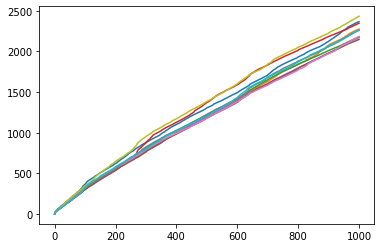

In [33]:
datasets, average_elapsed = visualise_logs('mpst', 1000)
print('Average elapsed:', average_elapsed, 'ms')

for xs, ys in datasets:
    plt.plot(xs, ys)